In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_dir = "data/raw-img" 

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float16),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
full_dataset = ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

In [6]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

In [7]:
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [9]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 256) 
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [10]:
model = MyModel(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = torch.amp.GradScaler('cuda')

In [11]:
train_losses = []
test_losses = []
f1_scores = []

best_f1 = 0
patience = 4
counter = 0


In [12]:
for epoch in range(25):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/25, Train Loss: {avg_train_loss:.4f}")
    
    model.eval()
    all_preds = []
    all_labels = []
    test_running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            test_running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_test_loss = test_running_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    f1_scores.append(f1)
    
    print(f"Test Loss: {avg_test_loss:.4f}, Test F1-Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        counter = 0  
    else:
        counter += 1  
        if counter >= patience:
            print("Early stopping triggered due to no improvement in F1-score for 4 consecutive epochs.")
            break
torch.save(model, "./model/model.pth")

Epoch 1/25, Train Loss: 2.0396
Test Loss: 1.6906, Test F1-Score: 0.3699
Epoch 2/25, Train Loss: 1.5094
Test Loss: 1.3854, Test F1-Score: 0.4972
Epoch 3/25, Train Loss: 1.1823
Test Loss: 1.1355, Test F1-Score: 0.6061
Epoch 4/25, Train Loss: 0.9943
Test Loss: 1.0933, Test F1-Score: 0.6357
Epoch 5/25, Train Loss: 0.8482
Test Loss: 0.9584, Test F1-Score: 0.6776
Epoch 6/25, Train Loss: 0.7369
Test Loss: 0.9593, Test F1-Score: 0.6735
Epoch 7/25, Train Loss: 0.6355
Test Loss: 0.9471, Test F1-Score: 0.6884
Epoch 8/25, Train Loss: 0.5552
Test Loss: 0.9975, Test F1-Score: 0.6917
Epoch 9/25, Train Loss: 0.4711
Test Loss: 0.9447, Test F1-Score: 0.7165
Epoch 10/25, Train Loss: 0.4041
Test Loss: 0.9503, Test F1-Score: 0.7067
Epoch 11/25, Train Loss: 0.3452
Test Loss: 1.0680, Test F1-Score: 0.7124
Epoch 12/25, Train Loss: 0.3052
Test Loss: 1.1166, Test F1-Score: 0.7146
Epoch 13/25, Train Loss: 0.2462
Test Loss: 1.1931, Test F1-Score: 0.7073
Early stopping triggered due to no improvement in F1-score f

In [13]:
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_f1 = f1_score(val_labels, val_preds, average='weighted')
print(f"Final Validation F1-Score: {val_f1:.4f}")

Final Validation F1-Score: 0.7148


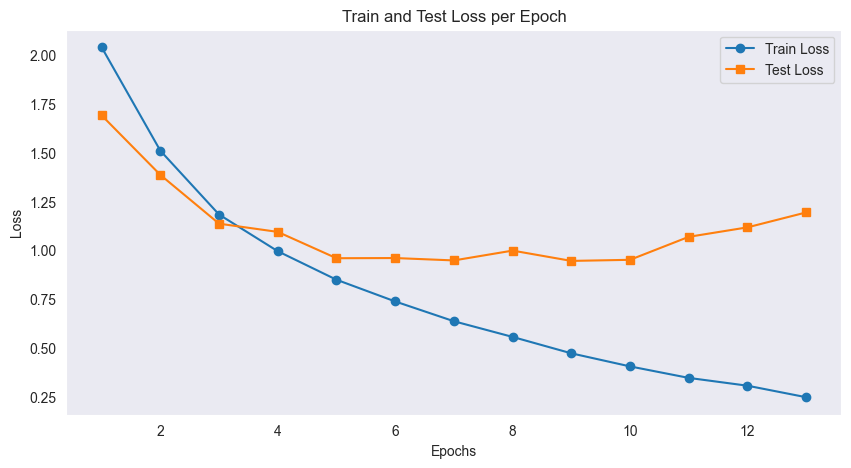

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

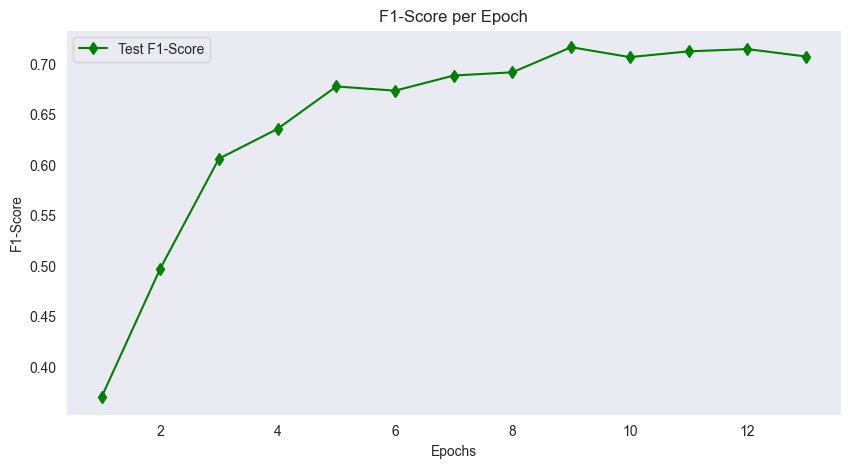

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, label='Test F1-Score', marker='d', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score per Epoch')
plt.legend()
plt.grid()
plt.show()
